# Group Proposal - Predicting Following Day Rainfall in Australia


## 1.0 Introduction

#### 1.1 Background

Meteorological data has been collected and used to predict weather conditions ever since we have had the means to do so - since 1869! It helps one plan their day ahead and deal with the given weather conditions accordingly.By predicting a rainy day, lots of variables need to be considered, such as wind, humidity, temperature, etc. 

#### 1.2 Central Question

Will it rain tomorrow in Australia based on a set of meteorological characteristics from the previous day?

#### 1.3 Dataset

The dataset that we will use is the “Rain in Australia” dataset by Joe Young and Adam Young. This dataset contains meteorological data across 10 years in Australia from 2007/10/31 to 2017/6/24 in various regions, collected by weather stations across Australia. The dataset contains variables such as weather conditions - wind speed, wind direction and temperature, as well the amount of precipitation in the form of rain on any given day.

## 2.0 Preliminiary Exploratory Data Analysis

#### 2.1 Wrangling

To aid in our decision for predictor variables, we can visualize which columns are present with the most valid data (least NA columns). A larger sample of data would allow us to reduce the impact of factors such as random error in the observation process and improve the overall quality of the analysis. 

In [1]:
#load tidyverse
library(tidyverse)
library(tidymodels)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.4     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.5     ✔ rsample      1.2.0
✔ dials        1.2.0     ✔ tune         1.1.2
✔ infer        1.0.5     ✔ workflows    1.1.3
✔ modeldata    1.2.0     ✔ workflowsets 1.0.1
✔ parsnip      1.1.1     ✔ yardstick    1.2.0
✔ recipes      1.0.8     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

In [2]:
#load data into r
weather_data_raw <- read_csv("weatherAUS.csv")
glimpse(weather_data_raw)

Rows: 145460 Columns: 23
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr   (6): Location, WindGustDir, WindDir9am, WindDir3pm, RainToday, RainTom...
dbl  (16): MinTemp, MaxTemp, Rainfall, Evaporation, Sunshine, WindGustSpeed,...
date  (1): Date

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Rows: 145,460
Columns: 23
$ Date          <date> 2008-12-01, 2008-12-02, 2008-12-03, 2008-12-04, 2008-12…
$ Location      <chr> "Albury", "Albury", "Albury", "Albury", "Albury", "Albur…
$ MinTemp       <dbl> 13.4, 7.4, 12.9, 9.2, 17.5, 14.6, 14.3, 7.7, 9.7, 13.1, …
$ MaxTemp       <dbl> 22.9, 25.1, 25.7, 28.0, 32.3, 29.7, 25.0, 26.7, 31.9, 30…
$ Rainfall      <dbl> 0.6, 0.0, 0.0, 0.0, 1.0, 0.2, 0.0, 0.0, 0.0, 1.4, 0.0, 2…
$ Evaporation   <dbl> NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, …
$ Sunshine      <dbl> NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, …
$ WindGustDir   <chr> "W", "WNW", "WSW", "NE", "W", "WNW", "W", "W", "NNW", "W…
$ WindGustSpeed <dbl> 44, 44, 46, 24, 41, 56, 50, 35, 80, 28, 30, 31, 61, 44, …
$ WindDir9am    <chr> "W", "NNW", "W", "SE", "ENE", "W", "SW", "SSE", "SE", "S…
$ WindDir3pm    <chr> "WNW", "WSW", "WSW", "E", "NW", "W", "W", "W", "NW", "SS…
$ WindSpeed9am  <dbl> 20, 4, 19, 11, 7, 19, 20, 6, 7, 15, 17, 15, 28, 24, 4, N…
$ WindSpeed3pm

In [4]:
# Summarizes each row by counting non N/A cells. Renames the variables afterwards after conversion to data frame
no_na_data <- as.data.frame((colSums(!is.na(weather_data_raw)))) 
no_na_data <- cbind(rownames(no_na_data), no_na_data)
rownames(no_na_data) <- NULL
colnames(no_na_data) <- c("measurement","count")

count_tbl <- arrange(no_na_data, desc(count))
count_tbl

measurement,count
<chr>,<dbl>
Date,145460
Location,145460
MaxTemp,144199
MinTemp,143975
WindSpeed9am,143693
Temp9am,143693
Humidity9am,142806
WindSpeed3pm,142398
Rainfall,142199


In [5]:
# Select three cities for analysis

options(repr.plot.width =14, repr.plot.height = 8) 

#Remove categorical variables & variables with too many N/A values (Wrangle Data)
weather_data_clean <- weather_data_raw |>
                            select(-WindGustDir, -WindDir9am, -WindDir3pm, -RainToday, -Date, -Location) |>
                            select(-Sunshine, -Evaporation, -Cloud3pm, -Cloud9am)

In [6]:
# Split training and testing sets
weather_split <- initial_split(weather_data_clean, prop = 0.75, strata = RainTomorrow)
weather_train <- training(weather_split)
weather_test <- testing(weather_split)

#### 2.2 Summarizing New Non N/A Rows
We can now check the distributions of usable rows within our training data by summarizing and counting the number of non N/A rows within our training data.

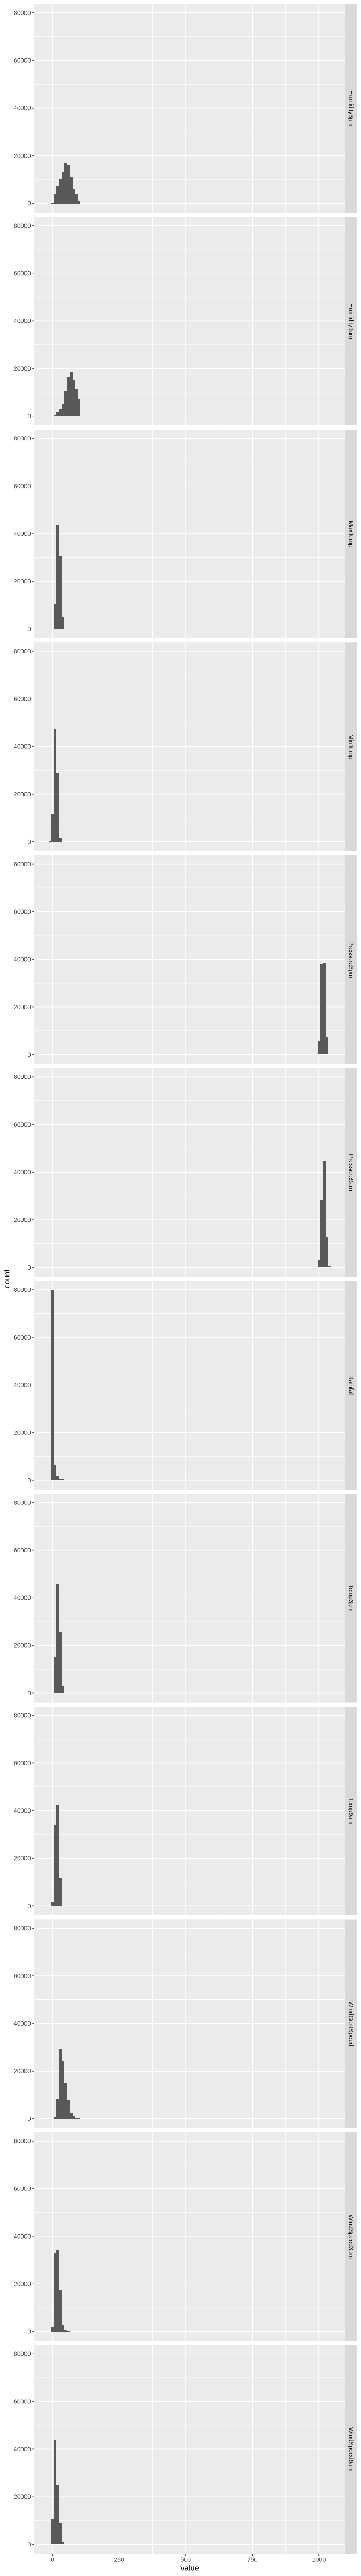

In [47]:
# Summarizes each row by counting non N/A cells. Renames the variables afterwards after conversion to data frame
no_na_data <- as.data.frame((colSums(!is.na(weather_train)))) 
no_na_data <- cbind(rownames(no_na_data), no_na_data)
rownames(no_na_data) <- NULL
colnames(no_na_data) <- c("measurement","count")

count_tbl <- arrange(no_na_data, desc(count))
# count_tbl


options(repr.plot.height = 50, repr.plot.width = 7)

plot <- na.omit(weather_train) |>
        select(-RainTomorrow) |>
        pivot_longer(cols= everything(), names_to="measurement", values_to="value") |>
        ggplot(aes(x=value)) +
            geom_histogram(bins=50, binwidth = 10) +
            facet_grid(rows=vars(measurement))
plot

In [7]:
# Summarizes each row by counting non N/A cells. Renames the variables afterwards after conversion to data frame
no_na_data <- as.data.frame((colSums(!is.na(weather_train)))) 
no_na_data <- cbind(rownames(no_na_data), no_na_data)
rownames(no_na_data) <- NULL
colnames(no_na_data) <- c("measurement","count")

count_tbl <- arrange(no_na_data, desc(count))
count_tbl

measurement,count
<chr>,<dbl>
MaxTemp,108149
MinTemp,107988
Temp9am,107781
WindSpeed9am,107770
Humidity9am,107108
WindSpeed3pm,106777
Rainfall,106666
RainTomorrow,106638
Temp3pm,106394


In [8]:
glimpse(weather_train)

Rows: 109,095
Columns: 13
$ MinTemp       <dbl> 13.4, 12.9, 9.2, 14.6, 14.3, 7.7, 13.1, 12.6, 11.2, 9.8,…
$ MaxTemp       <dbl> 22.9, 25.7, 28.0, 29.7, 25.0, 26.7, 30.1, 21.0, 22.5, 25…
$ Rainfall      <dbl> 0.6, 0.0, 0.0, 0.2, 0.0, 0.0, 1.4, 3.6, 10.6, 0.0, 0.0, …
$ WindGustSpeed <dbl> 44, 46, 24, 56, 50, 35, 28, 44, 43, 26, 24, 43, 41, 43, …
$ WindSpeed9am  <dbl> 20, 19, 11, 19, 20, 6, 15, 24, 24, 17, 9, 17, 19, 4, 9, …
$ WindSpeed3pm  <dbl> 24, 26, 9, 24, 24, 17, 11, 20, 17, 6, 9, 22, 20, 19, 13,…
$ Humidity9am   <dbl> 71, 38, 45, 55, 49, 48, 58, 65, 47, 45, 56, 38, 54, 49, …
$ Humidity3pm   <dbl> 22, 30, 16, 23, 19, 19, 27, 43, 32, 26, 28, 28, 24, 17, …
$ Pressure9am   <dbl> 1007.7, 1007.6, 1017.6, 1009.2, 1009.6, 1013.4, 1007.0, …
$ Pressure3pm   <dbl> 1007.1, 1008.7, 1012.8, 1005.4, 1008.2, 1010.1, 1005.7, …
$ Temp9am       <dbl> 16.9, 21.0, 18.1, 20.6, 18.1, 16.3, 20.1, 15.8, 15.5, 15…
$ Temp3pm       <dbl> 21.8, 23.2, 26.5, 28.9, 24.6, 25.5, 28.2, 19.8, 21.0, 23…
$ RainTomorrow

In [29]:
# Summary table
summary_weather_train <- weather_train|>
  summarize(
    Mean_MinTemp = mean(MinTemp, na.rm = TRUE),
    Mean_MaxTemp = mean(MaxTemp, na.rm = TRUE),
    Mean_Rainfall = mean(Rainfall, na.rm = TRUE),
    Mean_WindGustSpeed = mean(WindGustSpeed, na.rm = TRUE),
    Mean_WindSpeed9am = mean(WindSpeed9am, na.rm = TRUE),
    Mean_WindSpeed3pm = mean(WindSpeed3pm, na.rm = TRUE),
    Mean_Humidity9am = mean(Humidity9am, na.rm = TRUE),
    Mean_Humidity3pm = mean(Humidity3pm, na.rm = TRUE),
    Mean_Pressure9am = mean(Pressure9am, na.rm = TRUE),
    Mean_Pressure3pm = mean(Pressure3pm, na.rm = TRUE),
    Mean_Temp9am = mean(Temp9am, na.rm = TRUE),
    Mean_Temp3pm = mean(Temp3pm, na.rm = TRUE),    
    Rows_with_Missing_Data = sum(rowSums(is.na(weather_train)) > 0))|>
    as.data.frame()
summary_weather_train

summary_num_obs<-weather_train|>
  group_by(RainTomorrow)|>
  summarize(count=n())
summary_num_obs

Mean_MinTemp,Mean_MaxTemp,Mean_Rainfall,Mean_WindGustSpeed,Mean_WindSpeed9am,Mean_WindSpeed3pm,Mean_Humidity9am,Mean_Humidity3pm,Mean_Pressure9am,Mean_Pressure3pm,Mean_Temp9am,Mean_Temp3pm,Rows_with_Missing_Data
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
12.19227,23.21563,2.386528,40.04278,14.04813,18.6783,68.94697,51.5764,1017.664,1015.273,16.98097,21.67591,19373


RainTomorrow,count
<chr>,<int>
No,82734
Yes,23904
NA,2457


## 3.0 Methods

#### 3.1 Explain how you will conduct either your data analysis and which variables/columns you will use

The columns we plan to use are those quantifying the day’s weather with the least number of NA-observation counts. This includes minimum temperature, max temperature, rainfall level, humidity ,and windspeed. This has been proved by listing out the rows containing NA value with colSums!(is.na) function. Also, we will be plotting facet_grid histograms to compare the distributions of each predictor variable. To note as well, initial splitting by cross-validation has been done for the training results.


#### 3.2 Describe at least one way that you will visualize the results

We will make scatterplots to visualize the relationship between each pair of variables, such as “rainfall level” and “humidity”, and colored by the target variable to see if there is any pattern distinguishing whether it rains tomorrow or not.

## 4.0 Expected Outcomes and Significance:

#### 4.1 Expected Outcomes

We are expecting to create a design with an arithmetic trend with a specific date’s information to determine whether the next day rains. Therefore, the expected outcome would be accurately predicting the occurrence of rain on the next day.

#### 4.2 Significance of Investigation

The significance of this analysis lies in the immense impact that weather and in particular, rain, has on society. Being able to predict rain is not only beneficial for day-to-day life but quintessential for industries such as agriculture, tourism, and urban development

#### 4.3 Extended/Further Questions

Investigating precipitation further in the future can prompt inquiries on how rain patterns have evolved throughout the last decade. Furthermore, this investigation can also prompt further analysis into how accurate our model can be when compared to modern circumstances.